# Forecasting

In this lesson, we will practice forecasting using the following methods:

* Last observed value
* Simple average
* Moving average
* Holt's Linear Trend
* Previous cycle

We will acquire, prep, and split our data. Then we will forecast and evaluate using each model.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

## Acquire

We will acquire the store-item-demand data for this lesson from the sql database.

In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
query = '''
        select stores.*, items.*, sales.sale_date, sales.sale_amount
        from sales
        join stores using (store_id)
        join items using (item_id);
'''

df = pd.read_sql(query, get_connection('tsa_item_demand'))

In [4]:
df.head()

,store_id,store_address,store_zipcode,store_city,store_state,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_date,sale_amount
0,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-01,13
1,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-02,11
2,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-03,14
3,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-04,13
4,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-05,10


### Prepare

In [5]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date)).\
            sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            assign(items_sold = df.sale_amount).\
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().\
            reset_index().set_index('ds')

df = prep_data(df)

df = df[df.index != '2016-02-29']

In [6]:
df

,dollars_sold,items_sold
ds,,
2013-01-01,73844.01,13696
2013-01-02,73570.58,13678
2013-01-03,78169.48,14488
2013-01-04,84467.73,15677
2013-01-05,87621.85,16237
...,...,...
2017-12-27,109151.15,20378
2017-12-28,117377.49,21885
2017-12-29,126541.84,23535


### Split

In [11]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

#### Verify Splits

In [12]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [13]:
print(df.head(1) == train.head(1))

            dollars_sold  items_sold
ds                                  
2013-01-01          True        True


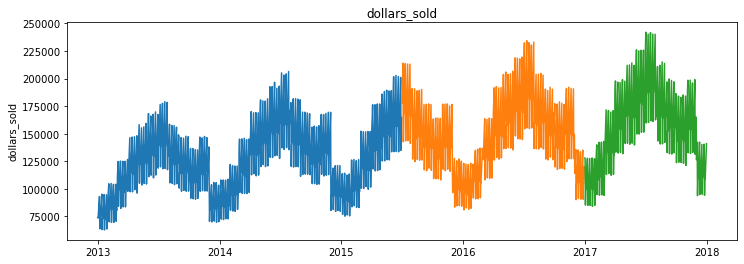

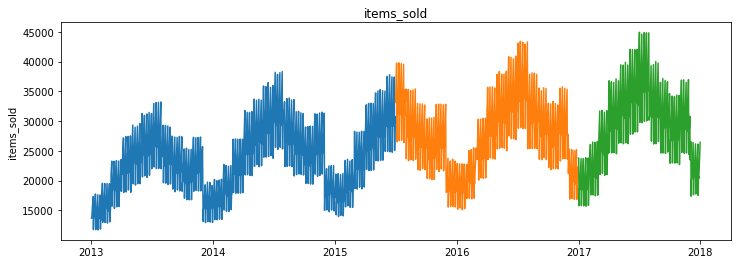

In [14]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

Before tyring the different methods for forecasting sales we will create a couple of functions that will be helpful in evaluating each of the methods that follow.

### Create a function that will compute the Mean Squared Error and the Root Mean Squared Error to evaluate.

In [15]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

### Create a function that will use the evaluate function and plot the train and test values with the predicted values in order to compare the the performance of the forecast to the actual values.

In [23]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var], label = 'yhat', linewidth = 1)
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, ' -- RMSE: {:.0f}'.format(rmse))
    plt.show()

### Create a function that will append the evaluation metrics for each model type, target variable, and metric type, along with the metric value into our eval_df dataframe object. Which we will create an empty eval_df dataframe object to start.

In [17]:
# Create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# Create a function to store rmse values for each forecast method.
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [18]:
eval_df

,model_type,target_var,rmse


## Forecast
### 1) Last Observed Value 
The simplest method for forecasting is to predict all future values to be the last observed value.

**Make Predictions**

In [19]:
items = train['items_sold'][-1:][0]
dollars = round(train['dollars_sold'][-1:][0],2)

yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]},
                      index = validate.index)

yhat_df.head(5)

,items_sold,dollars_sold
ds,,
2015-07-02,30703,164573.2
2015-07-03,30703,164573.2
2015-07-04,30703,164573.2
2015-07-05,30703,164573.2
2015-07-06,30703,164573.2


**Using this method will take the specified value and apply it to all future occurences.**

dollars_sold  -- RMSE: 35402


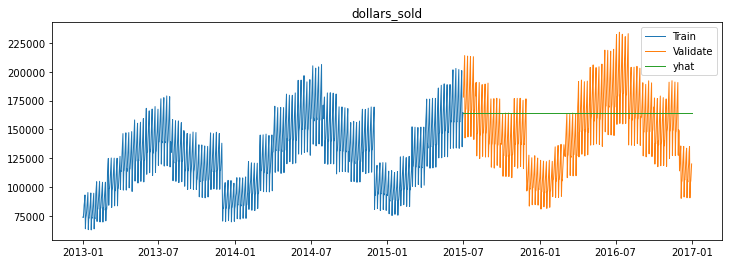

items_sold  -- RMSE: 6621


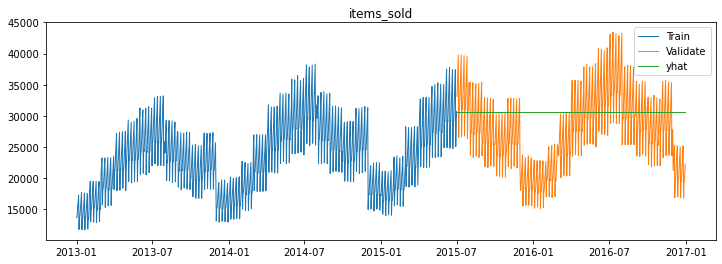

In [24]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**
Evaluate the 'Last Observed Value' method using MSE and RMSE, and add evaluation metrics to eval_df

In [25]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                            target_var = col)
    
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0


### 2) Simple Average (maybe a good option for baseline)
Take the simple average of historical values and use that value to predict future values.

This is a good option for an initial baseline. Every future datapoint(those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

**Make Predictions**

In [26]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'items_sold': [items],
                           'dollars_sold': [dollars]},
                          index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [27]:
yhat_df

,items_sold,dollars_sold
ds,,
2015-07-02,23717.94,127517.85
2015-07-03,23717.94,127517.85
2015-07-04,23717.94,127517.85
2015-07-05,23717.94,127517.85
2015-07-06,23717.94,127517.85
...,...,...
2016-12-26,23717.94,127517.85
2016-12-27,23717.94,127517.85
2016-12-28,23717.94,127517.85


**Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performace of our time series model using **Simple Average**.

dollars_sold  -- RMSE: 39664


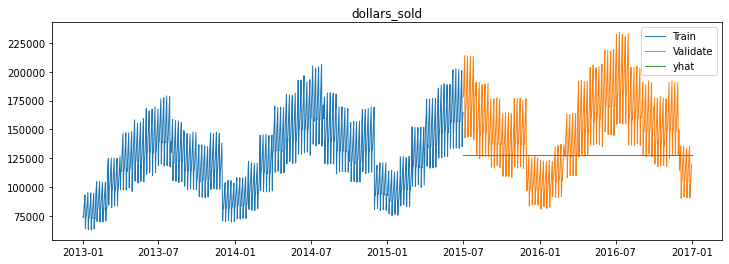

items_sold  -- RMSE: 7378


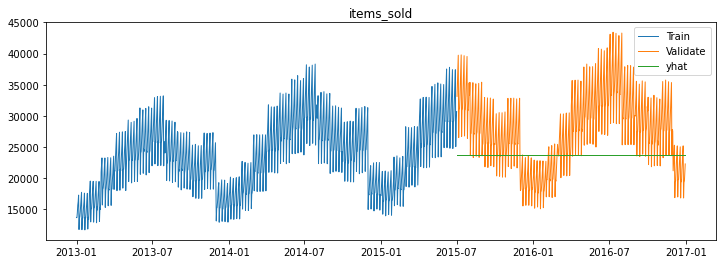

In [28]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**
Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [29]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average',
                       target_var = col)

In [30]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0


### 3) Moving Average

For this method we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

**Make Predictions**

In [31]:
# compute a 30 day rolling average
# use the most recent/last 30 day period value to predict forward.

period = 30

items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df

,items_sold,dollars_sold
ds,,
2015-07-02,31432.77,168957.91
2015-07-03,31432.77,168957.91
2015-07-04,31432.77,168957.91
2015-07-05,31432.77,168957.91
2015-07-06,31432.77,168957.91
...,...,...
2016-12-26,31432.77,168957.91
2016-12-27,31432.77,168957.91
2016-12-28,31432.77,168957.91


**Plot Actual vs. Predicted Values

Now, we will plot and evaluate the performance of our time series model using **Moving Average**.

dollars_sold  -- RMSE: 37378


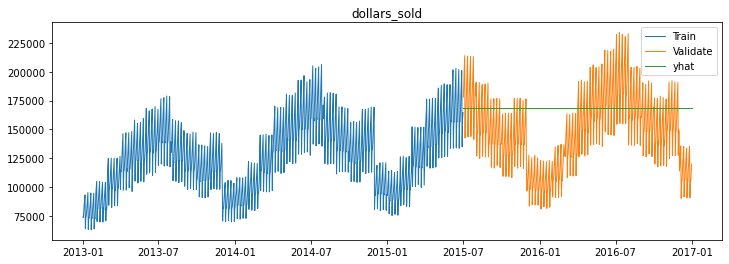

items_sold  -- RMSE: 6954


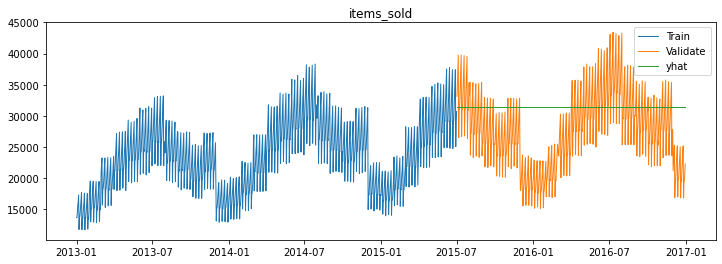

In [32]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**
Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [33]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30-day Moving Average',
                            target_var = col)

In [34]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30-day Moving Average,dollars_sold,37378.0
5,30-day Moving Average,items_sold,6954.0


We'll try out several other values for periods:

In [35]:
periods = [1,4,12,26,52,104]

for p in periods:
    items = round(train['items_sold'].rolling(p).mean().iloc[-1],2)
    dollars = round(train['dollars_sold'].rolling(p).mean().iloc[-1],2)
    yhat_df = make_predictions()
    model_type = str(p) + '-day moving average'
    eval_df = append_eval_df(model_type = model_type,
                               target_var = 'items_sold')
    eval_df = append_eval_df(model_type = model_type,
                            target_var = 'dollars_sold')
    

In [36]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30-day Moving Average,dollars_sold,37378.0
5,30-day Moving Average,items_sold,6954.0
6,1-day moving average,items_sold,6621.0
7,1-day moving average,dollars_sold,35402.0
8,4-day moving average,items_sold,6592.0
9,4-day moving average,dollars_sold,35515.0


Which period is best so far(lowest rmse value)?

In [37]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) |
        (eval_df.rmse == min_rmse_items_sold))]

,model_type,target_var,rmse
16,104-day moving average,items_sold,6101.0
17,104-day moving average,dollars_sold,32803.0


### 4) Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).
* α / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
* β / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.

**Seasonal Decomposition**
First, let's take a look at the seasonal decomposition for each target.

dollars_sold 



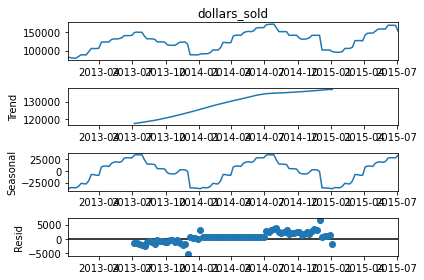

items_sold 



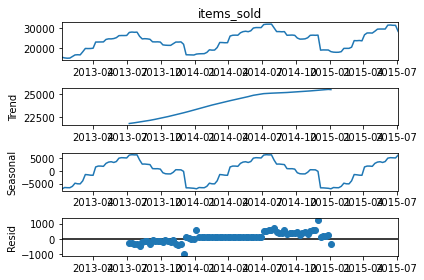

In [40]:
import statsmodels.api as sm

for col in train.columns:
    print(col, '\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

#### Basic Holt's Linear Trend

**Make Predictions**

With Holt's Linear Trend method we must create the Holt object, fit the model, and use it to make predictions on the validate/test datasets.

Holt:
* exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit:

* smoothing_level(α): value between (0,1)
* smoothing_slope(β): value between (0,1)

In [41]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1,
                     smoothing_slope = .1,
                     optimized = False)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [42]:
yhat_df

,items_sold,dollars_sold
ds,,
2015-07-02,31670.90,170251.51
2015-07-03,31660.56,170200.14
2015-07-04,31650.22,170148.77
2015-07-05,31639.88,170097.41
2015-07-06,31629.54,170046.04
...,...,...
2016-12-26,26056.33,142359.74
2016-12-27,26045.99,142308.37
2016-12-28,26035.65,142257.01


#### Plot Actual vs. Predicted Values

dollars_sold  -- RMSE: 34700


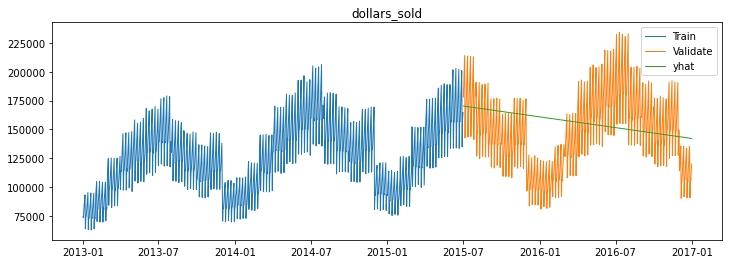

items_sold  -- RMSE: 6464


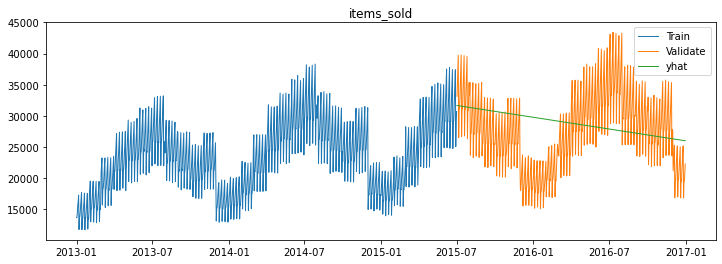

In [43]:
for col in train.columns:
    plot_and_eval(target_var = col)

### Evaluate

In [44]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts',
                            target_var = col)

In [45]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30-day Moving Average,dollars_sold,37378.0
5,30-day Moving Average,items_sold,6954.0
6,1-day moving average,items_sold,6621.0
7,1-day moving average,dollars_sold,35402.0
8,4-day moving average,items_sold,6592.0
9,4-day moving average,dollars_sold,35515.0


### 5) Previous Cycle Method

Take all the data points from the previous cycle, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day.

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence.

In the below example:
1. Compute the 365 average year over year differences from 2013 to 2015

2. Add that average delta to the values during 2015.

3. Set the index in your yhat dataframe to represent the dates those predictions are made for.

Here we go again...

**Re-split data**

In [46]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

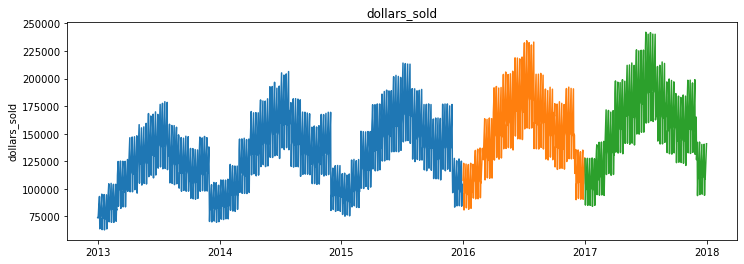

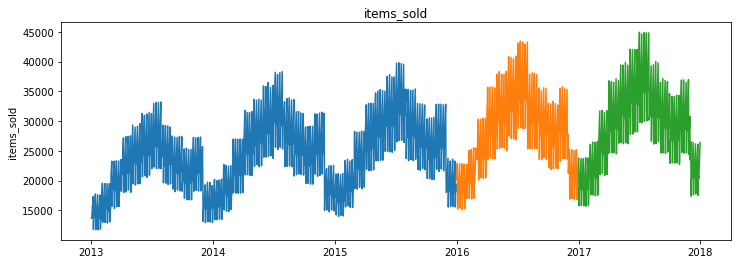

In [47]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

**Make Predictions**

In [48]:
yhat_df = train['2015'] + train.diff(365).mean()

In [49]:
pd.concat([yhat_df.head(1), validate.head(1)])

,dollars_sold,items_sold
ds,,
2015-01-01,104337.620493,19411.813699
2016-01-01,107875.260000,20158.000000


In [50]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

365

**Plot and Evaluate**

dollars_sold  -- RMSE: 28087


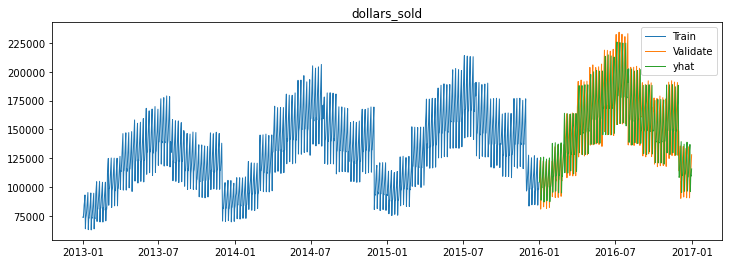

items_sold  -- RMSE: 5223


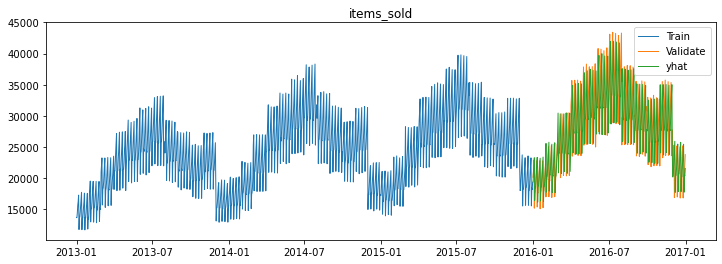

In [51]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [52]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30-day Moving Average,dollars_sold,37378.0
5,30-day Moving Average,items_sold,6954.0
6,1-day moving average,items_sold,6621.0
7,1-day moving average,dollars_sold,35402.0
8,4-day moving average,items_sold,6592.0
9,4-day moving average,dollars_sold,35515.0


### Conclusion

Which model did the best?

In [53]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out
# which models are best thus far

eval_df[((eval_df.rmse == min_rmse_dollars_sold) |
        (eval_df.rmse == min_rmse_items_sold))]

,model_type,target_var,rmse
20,previous year,dollars_sold,28087.0
21,previous year,items_sold,5223.0


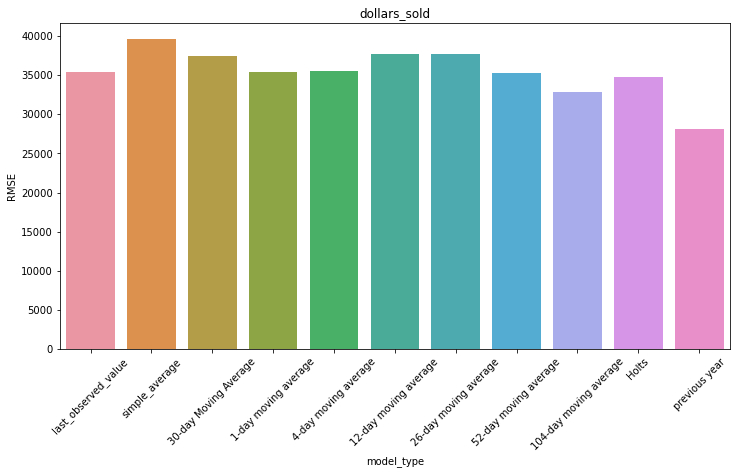

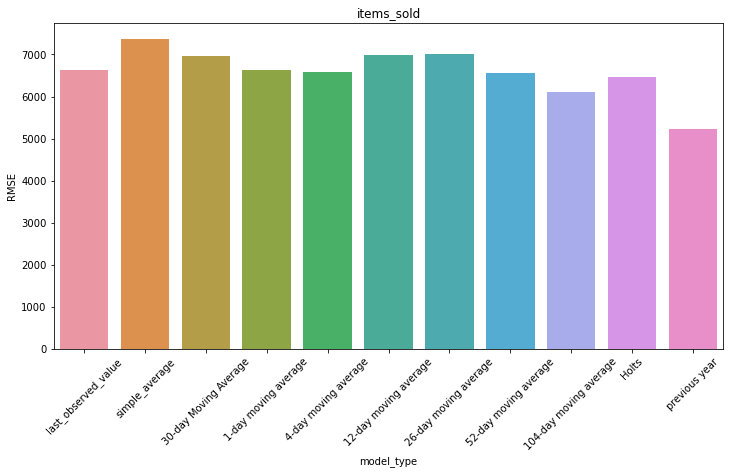

In [54]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12,6))
    sns.barplot(x,y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

### Let's test it out on our out-of-sample data.
### We will be using train + validate to predict test.

In [55]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [57]:
yhat_df

,dollars_sold,items_sold
ds,,
2017-01-01,119626.510493,22343.813699
2017-01-02,126081.680493,23465.813699
2017-01-03,134896.160493,25096.813699
2017-01-04,92625.220493,17384.813699
2017-01-05,107181.150493,19991.813699
...,...,...
2017-12-27,115409.140493,21526.813699
2017-12-28,117065.190493,21745.813699
2017-12-29,124973.100493,23296.813699


In [56]:
rmse_dollars = round(sqrt(mean_squared_error(test['dollars_sold'], yhat_df['dollars_sold'])),0)
rmse_items = round(sqrt(mean_squared_error(test['items_sold'], yhat_df['items_sold'])),0)

In [74]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], label = 'yhat', alpha=.2)
    plt.legend()
    plt.title(target_var)
    plt.show()

rmse - dollars sold:  27115.0
rmse - items_sold:  5041.0


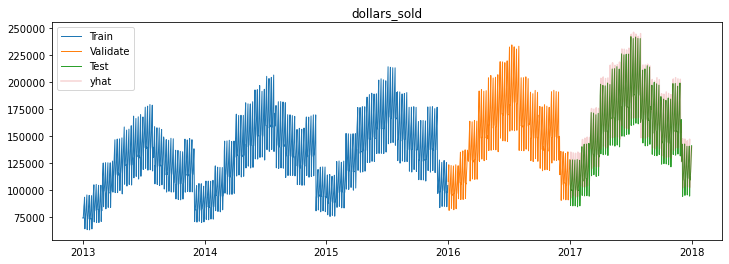

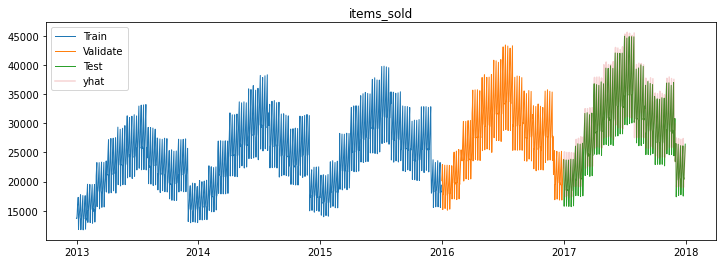

In [75]:
print("rmse - dollars sold: ", rmse_dollars)
print("rmse - items_sold: ", rmse_items)

for col in train.columns:
    plot_and_eval(col)

### Takeaways
* The 'previous year' forecasting method performed well on the test dataset.
* Recommendations: Use the 'previous year' method to predict future values.